In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open(r'/content/drive/MyDrive/makemore/names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:(i+1) for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {(i+1):s for i,s in enumerate(chars)}
itos[0] = '.'

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one
X,Y = [],[]
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w+'.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '------>', itos[ix])
    context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ------> e
..e ------> m
.em ------> m
emm ------> a
mma ------> .
olivia
... ------> o
..o ------> l
.ol ------> i
oli ------> v
liv ------> i
ivi ------> a
via ------> .
ava
... ------> a
..a ------> v
.av ------> a
ava ------> .
isabella
... ------> i
..i ------> s
.is ------> a
isa ------> b
sab ------> e
abe ------> l
bel ------> l
ell ------> a
lla ------> .
sophia
... ------> s
..s ------> o
.so ------> p
sop ------> h
oph ------> i
phi ------> a
hia ------> .


In [6]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
# matrix C is used to embed the character (one-hot vector of length 27) into a 2 dimensions vector
C = torch.randn((27,2))

In [8]:
# each sample have 3 features, each feature is one-hot encoded to a 27 dimensions vector, and each one-hot vector is embedded into a 2 dimensions vector
# so for each sample, there are 2*3=6 features
emb = C[X] # it's equal to F.one_hot(X,num_classes=27).float() @ C
emb.shape

torch.Size([32, 3, 2])

In [9]:
# initialize the first layer with 100 neurons
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [10]:
# note emb is 32*3*2, so we have to reshape it to 32*6
# the difference between reshape and view:
# view is more memory-efficient, for A = B.view(...), if A changes, B changes too
# reshape makes a copy of the original data, for A = B.reshape(...), if A changes, B does NOT change
h = emb.view(emb.shape[0],-1) @ W1 + b1

In [11]:
# review on why the broadcasting works
print((emb.view(emb.shape[0],-1) @ W1).shape)
print(b1.shape)
# so according to the broadcasting rule
# 32 100
#   100  align to the right

torch.Size([32, 100])
torch.Size([100])


In [12]:
# initialize the second, which is also the last, layer
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [13]:
logits = h @ W2 + b2
counts = logits.exp()
probs = counts/counts.sum(dim=1,keepdim=True)
probs.shape

torch.Size([32, 27])

In [14]:
loss = -probs[torch.arange(32),Y].log().mean()
loss

tensor(43.3042)

In [15]:
# now let's wrap it up
print(X.shape,Y.shape)
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]
sum(param.nelement() for param in parameters) # number of parameters in total

torch.Size([32, 3]) torch.Size([32])


3481

In [16]:
# forward pass
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1) # add an activation function
logits = h @ W2 + b2

# before
# counts = logits.exp()
# probs = counts/counts.sum(dim=1,keepdim=True)
# loss = -probs[torch.arange(32),Y].log().mean()

# now let's use cross_entropy for multi classification, which will generate the same result
loss = F.cross_entropy(logits,Y)
loss

tensor(17.7697)

In [17]:
# why we should use F.cross_entropy() instead of what we did before in practice:
# 1. pytorch does not create all the intermediate tensors, which is very memory-inefficient
# 2. backward path will be much more efficient
# 3. more numerically well behaved. here is an example
# some values are very extreme, which may appear during optimization, for example -100 and 100
logits = torch.tensor([-100,-3,0,100])
counts = logits.exp()
probs = counts/counts.sum()
counts,probs
# now the counts have a inf number, and probs have a nan number

(tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf]),
 tensor([0., 0., 0., nan]))

In [18]:
# however, if we add an offset, the probs will work, and pytorch will add this offset for us efficiently
logits = torch.tensor([-100,-3,0,4]) - 4 # note: with or without this offset, the probs will result the same
counts = logits.exp()
probs = counts/counts.sum()
probs

tensor([0.0000e+00, 8.9468e-04, 1.7970e-02, 9.8114e-01])

In [19]:
# now let's add backward pass and put them together
for p in parameters:
  p.requires_grad = True

for _ in range(1000):
  # forward pass
  emb = C[X]
  h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Y)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data -= 0.1 * p.grad

print(loss.item())
# we have a very low loss for the training set, and get overfitting :(

0.2561509907245636


In [20]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3437, 17.7879, 20.5832, 20.6042, 16.7390, 13.3437, 15.9747, 14.1889,
        15.9158, 18.3894, 15.9409, 20.9284, 13.3437, 17.1212, 17.1498, 20.0637,
        13.3437, 16.4564, 15.1328, 17.0537, 18.5905, 15.9655, 10.8739, 10.6874,
        15.5062, 13.3437, 16.2394, 16.9563, 12.7426, 16.2141, 19.0840, 16.0213],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

In [21]:
Y
# we can see that the indices the model predicts are pretty close to the ground true labels
# but we are not able to get loss=0
# because we can see that for the beginning of a word, a ... can predict almost any character

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [22]:
# now let's train the model on the whole dataset
# for practice, I'll write all the codes again
X,Y = [],[]
block_size = 3
for w in words:
  context = [0] * block_size
  for ch in w+'.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape,Y.shape)

# initialize the net
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn((100),generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn((27),generator=g)
parameters = [C,W1,b1,W2,b2]
print('number of parameters:',sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True

for _ in range(10):
  # forward pass
  emb = C[X]
  h = torch.tanh(emb.view(emb.shape[0],-1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data -= 0.1 * p.grad

torch.Size([228146, 3]) torch.Size([228146])
number of parameters: 3481
19.505226135253906
17.08449363708496
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.051856994628906


In [31]:
# every epoch takes quite a long time, because there are too many samples (228146) to train for one epoch
# now it's time to batch
for _ in range(100):
  # minibatch construct
  ix = torch.randint(0,X.shape[0],(32,)) # it generates 32 random int numbers between 0 and X.shape[0]
  # forward
  emb = C[X[ix]]
  h = torch.tanh(emb.view(X[ix].shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Y[ix])
  # backward
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  for p in parameters:
    p.data -= 0.1*p.grad
print(loss.item())
# now it's much faster and roughly to the right direction

3.0235047340393066


In [32]:
# the loss for the entire dataset
emb = C[X]
h = torch.tanh(emb.view(X.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Y)
loss.item()
# it's pretty much the same

2.9217283725738525

In [ ]:
# now let's find a reasonable learning rate instead of a random guess (though 0.1 is quite reasonable)
# reset the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn((100),generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn((27),generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
  p.requires_grad = True

for _ in range(100):
  # minibatch
  ix = torch.randint(0,X.shape[0],(32,))

  # forward
  emb = C[X[ix]]
  h = torch.tanh(emb.view(X[ix].shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Y[ix])
  print(loss.item())

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data -= 10*p.grad
# if lr=0.0001, the loss barely decreases
# if lr=0.001, the loss decreases slowly
# if lr=1, the loss decreases fast but is quite unstable (goes up and down)
# if lr=10, the loss even increases
# so the reasonable range for the learning rate maybe is [0.0001,1]

In [39]:
# one way to set learning rate range is
lr = torch.linspace(0.0001,1,1000)
# but there's no reason to take 1000 values linearly. A more efficient way is
lre = torch.linspace(-3,0,1000)
lrs = 10**lre # 10^(-3)=0.0001,10^0=1

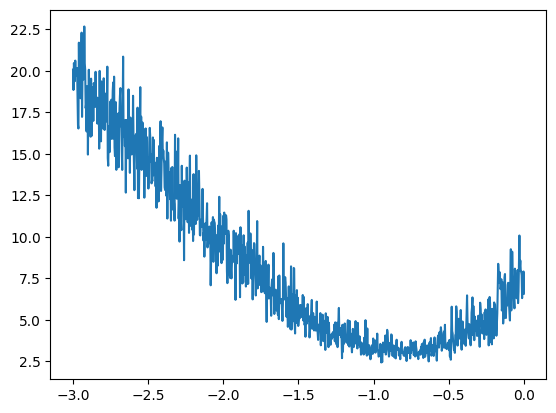

In [40]:
# next, let's track the loss for different learning rate
# reset the parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn((100),generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn((27),generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
  p.requires_grad = True

lri = []
lossi = []

for i in range(1000):
  # minibatch
  ix = torch.randint(0,X.shape[0],(32,))

  # forward
  emb = C[X[ix]]
  h = torch.tanh(emb.view(X[ix].shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Y[ix])
  #print(loss.item())

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data -= lr*p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

plt.plot(lri,lossi)
# from the plot, we can see that 10^(-1.0) is fairly a good choice
# plus, we can implement learning rate decay, which is,
# roughly speaking, train the model with one learning rate for a while, then use a smaller learning rate to train the model, then again and again

In [42]:
# train/validation/test split -- 80%,10%,10%
# training set is used to train the parameters
# validation set is used to train the hyperparameters
# test set is used to evaluate the performance of the model at the end
# now let's split the whole dataset

def build_dataset(words):
  block_size = 3
  X,Y = [],[]
  for w in words:
    context = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [46]:
# now we will only use the training set to train our model
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn((100),generator=g)
W2 = torch.randn((100,27),generator=g)
b2 = torch.randn((27),generator=g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
  p.requires_grad = True

for i in range(10000):
  # minibatch
  ix = torch.randint(0,Xtr.shape[0],(32,))

  # forward
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(Xtr[ix].shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Ytr[ix])
  #print(loss.item())

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1
  for p in parameters:
    p.data -= lr*p.grad
print(loss.item())

2.4413938522338867


In [48]:
# the loss on the entire training set
emb = C[Xtr]
h = torch.tanh(emb.view(Xtr.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ytr)
loss.item()

2.4916107654571533

In [47]:
# then let's evaluate the loss using the dev set
emb = C[Xdev]
h = torch.tanh(emb.view(Xdev.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ydev)
loss.item()
# it's very close to the loss on the training set, so we're not overfitting
# but the network is too tiny to overfit, it may suffer from underfitting now

2.490128517150879

In [52]:
# so let's try a more complicated network: one layer with 300 neurons
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,300),generator=g)
b1 = torch.randn((300),generator=g)
W2 = torch.randn((300,27),generator=g)
b2 = torch.randn((27),generator=g)
parameters = [C,W1,b1,W2,b2]
num_parameters = sum([p.nelement() for p in parameters])
print(num_parameters)

for p in parameters:
  p.requires_grad = True

lossi = []
stepi = []

for i in range(30000):
  ix = torch.randint(0,Xtr.shape[0],(32,))

  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(Xtr[ix].shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Ytr[ix])

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1
  for p in parameters:
    p.data -= lr*p.grad

  stepi.append(i)
  lossi.append(loss.item())

10281


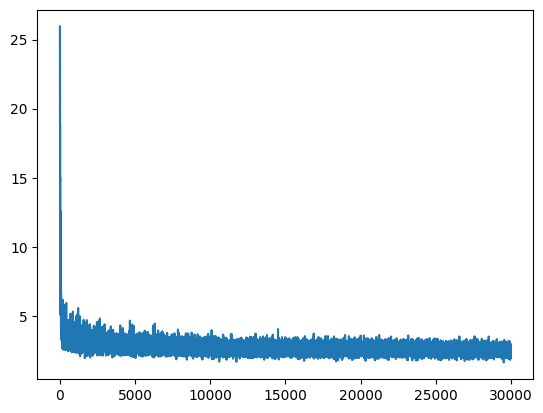

In [53]:
plt.plot(stepi,lossi)

In [54]:
# let's see the loss on the entire training set and dev set
emb = C[Xtr]
h = torch.tanh(emb.view(Xtr.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ytr)
print(loss.item())
emb = C[Xdev]
h = torch.tanh(emb.view(Xdev.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ydev)
print(loss.item())

2.4961845874786377
2.501142740249634


In [63]:
# let's keep training
lossi = []
stepi = []

for i in range(30000):
  ix = torch.randint(0,Xtr.shape[0],(32,))

  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(Xtr[ix].shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Ytr[ix])

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.05
  for p in parameters:
    p.data -= lr*p.grad

  stepi.append(i)
  lossi.append(loss.item())

In [64]:
emb = C[Xtr]
h = torch.tanh(emb.view(Xtr.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ytr)
print(loss.item())
emb = C[Xdev]
h = torch.tanh(emb.view(Xdev.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ydev)
print(loss.item())
# we can see the loss is better than the simpler network
# but it's still not good enough
# the bottlenet may be the embedding size, we embed a 27-length vector into a 2-length vector
# next, let's work on that

2.310014009475708
2.321054458618164


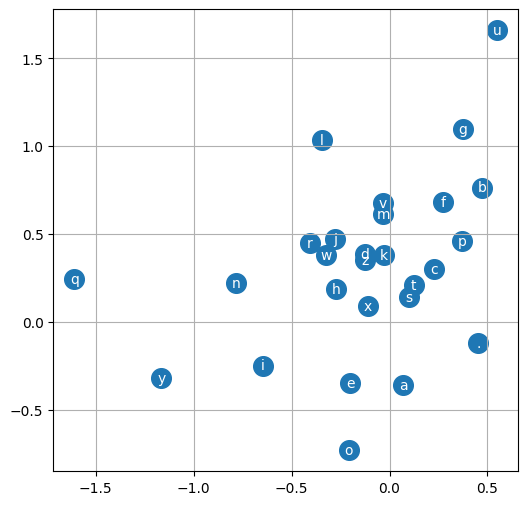

In [65]:
# first, let's visualize the 2-dim embeddings
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha='center',va='center',color='white')
plt.grid('minor')
# we can get some sense from this plot
# a e i o are close (don't know why u is also an outlier, unlike what's shown in the video)
# q and . is kind of a outlier
# other characters cluster together

In [68]:
# so let's try a bigger embedding with a smaller network
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g)
b1 = torch.randn((200),generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn((27),generator=g)
parameters = [C,W1,b1,W2,b2]
num_parameters = sum([p.nelement() for p in parameters])
print(num_parameters)

for p in parameters:
  p.requires_grad = True

lossi = []
stepi = []

11897


In [77]:
# we may run this cell several times
for i in range(30000):
  ix = torch.randint(0,Xtr.shape[0],(32,))

  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(Xtr[ix].shape[0],-1)@W1+b1)
  logits = h@W2+b2
  loss = F.cross_entropy(logits,Ytr[ix])

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.01
  for p in parameters:
    p.data -= lr*p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())

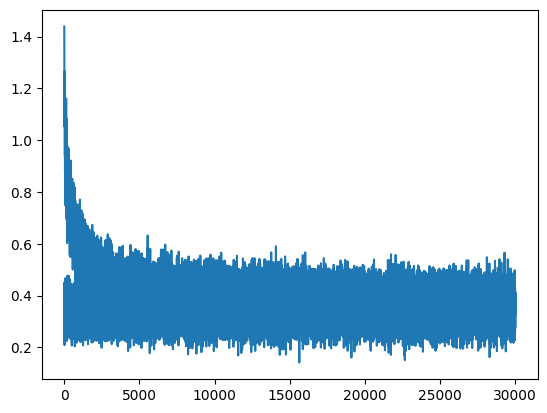

In [75]:
plt.plot(stepi,lossi)

In [78]:
emb = C[Xtr]
h = torch.tanh(emb.view(Xtr.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ytr)
print(loss.item())
emb = C[Xdev]
h = torch.tanh(emb.view(Xdev.shape[0],-1)@W1+b1)
logits = h@W2+b2
loss = F.cross_entropy(logits,Ydev)
print(loss.item())
# it works better than before, so it is the embedding size that holds us back

2.208723306655884
2.234503984451294


In [ ]:
# several things we can do to optimize (or say get a smaller loss):
# 1.change the number of layers or the number of neurons
# 2.change the size of embeddings or the size of context
# 3.change the details of the optimization: number of epoches, learning rate, learning rate decay, batch size

In [79]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
  out = []
  context = [0]*block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(emb.shape[0],-1)@W1+b1)
    logits = h@W2+b2
    probs = F.softmax(logits,dim=1)
    ix = torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join([itos[i] for i in out]))

mora.
kayah.
see.
mad.
ryah.
rethrstengrlee.
aderedieliigh.
pore.
leigh.
estanar.
kateimarkelin.
shubergiai.
jest.
jaireth.
konnterianu.
zen.
daryyah.
faeha.
kaysh.
samyah.
